In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:

dfc = pd.read_json("../sources/florida/data/data.json.gz")
dfc = dfc.drop(["edvisit","county","age_group","chartdate","case","case_"],axis=1, errors="ignore")
dfc = dfc.rename({"case1":"case"},axis=1)

dfc["died"] = dfc["died"].map({"Yes":True,"NA":False}).fillna(False)

dfc = dfc[dfc["age"] != "NA"]
dfc = dfc[~dfc["age"].isna()]
dfc = dfc[dfc["gender"] != "Unknown"]
dfc["gender"] = dfc["gender"].str[0]
# dfc["age"] = dfc["age"].astype(int)

for k in ["case","eventdate"]:
    dfc[k] = pd.to_datetime(dfc[k].str.split(" ",1).str[0])
#     dfc[k] = pd.to_datetime(dfc[k], unit="ms")
dfc["known_status"] = (dfc["hospitalized"]=="YES") | (dfc["hospitalized"]=="NO")


# data entry error, off by a year
# dfc.loc[dfc["eventdate"] < pd.Timestamp("2019-11-01"), "eventdate"] += pd.Timedelta("1y")

dfc.head()

/Users/namin/Library/Python/3.7/lib/python/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,age,gender,hospitalized,died,case,eventdate,known_status
0,83.0,M,YES,True,2020-05-26,2020-05-19,True
1,25.0,M,NO,False,2020-05-25,2020-05-21,True
2,31.0,M,NO,False,2020-05-25,2020-05-25,True
3,19.0,M,NO,False,2020-05-25,2020-05-07,True
4,49.0,F,NO,False,2020-06-09,2020-06-09,True


In [3]:
dfc["died"].value_counts()

False    66064
True      2938
Name: died, dtype: int64

In [4]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69002 entries, 0 to 69068
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   age           69002 non-null  float64       
 1   gender        69002 non-null  object        
 2   hospitalized  68503 non-null  object        
 3   died          69002 non-null  bool          
 4   case          69002 non-null  datetime64[ns]
 5   eventdate     69002 non-null  datetime64[ns]
 6   known_status  69002 non-null  bool          
dtypes: bool(2), datetime64[ns](2), float64(1), object(2)
memory usage: 3.3+ MB


In [5]:
dfc["gender"].value_counts()

F    35020
M    33982
Name: gender, dtype: int64

In [6]:
dfc["hospitalized"].value_counts()

NO         44033
UNKNOWN    12621
YES        11849
Name: hospitalized, dtype: int64

In [7]:
from yahist import Hist1D
from yahist.utils import set_default_style
set_default_style()

In [8]:
dfc["age"].isna().sum()

0

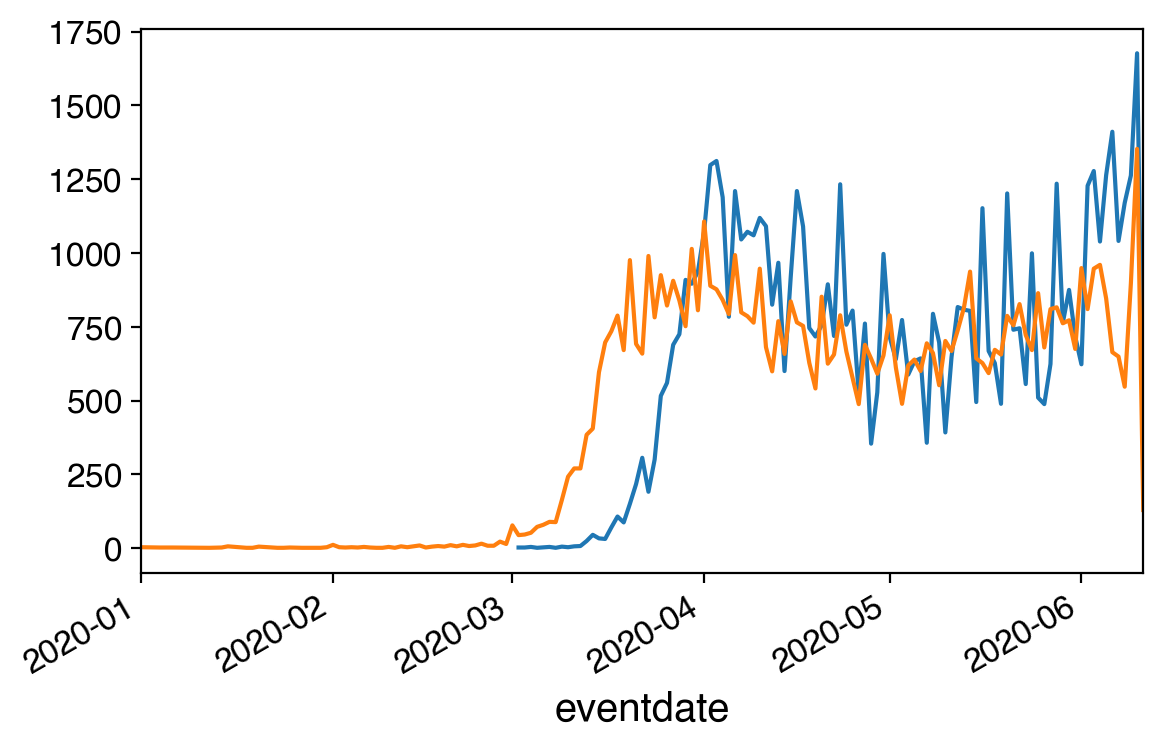

In [9]:
dfc.groupby("case")["gender"].count().plot()
dfc.groupby("eventdate")["gender"].count().plot()

In [10]:
# dfc.hospitalized.value_counts()

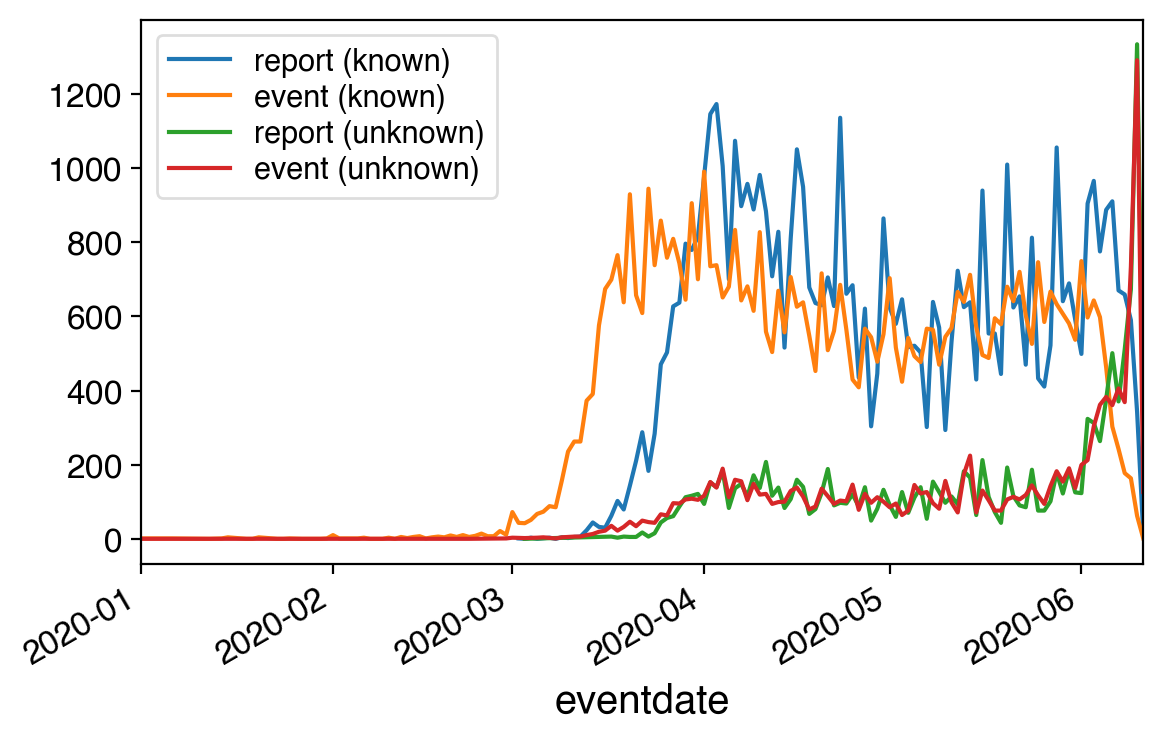

In [11]:
df = dfc.query("known_status")
df.groupby("case")["gender"].count().plot(label="report (known)")
df.groupby("eventdate")["gender"].count().plot(label="event (known)")

df = dfc.query("not known_status")
df.groupby("case")["gender"].count().plot(label="report (unknown)")
df.groupby("eventdate")["gender"].count().plot(label="event (unknown)")

plt.gca().legend()

In [12]:
dfc.sort_values("eventdate")

,age,gender,hospitalized,died,case,eventdate,known_status
48942,56.0,F,NO,False,2020-04-25,2020-01-01,True
50032,75.0,F,NO,False,2020-04-26,2020-01-01,True
32867,4.0,F,UNKNOWN,False,2020-04-08,2020-01-01,False
19136,56.0,F,NO,False,2020-03-25,2020-01-04,True
17156,65.0,M,YES,False,2020-03-07,2020-01-04,True
...,...,...,...,...,...,...,...
15234,22.0,M,UNKNOWN,False,2020-06-11,2020-06-11,False
15233,34.0,M,UNKNOWN,False,2020-06-11,2020-06-11,False
15232,30.0,F,UNKNOWN,False,2020-06-11,2020-06-11,False
13686,22.0,F,UNKNOWN,False,2020-06-11,2020-06-11,False


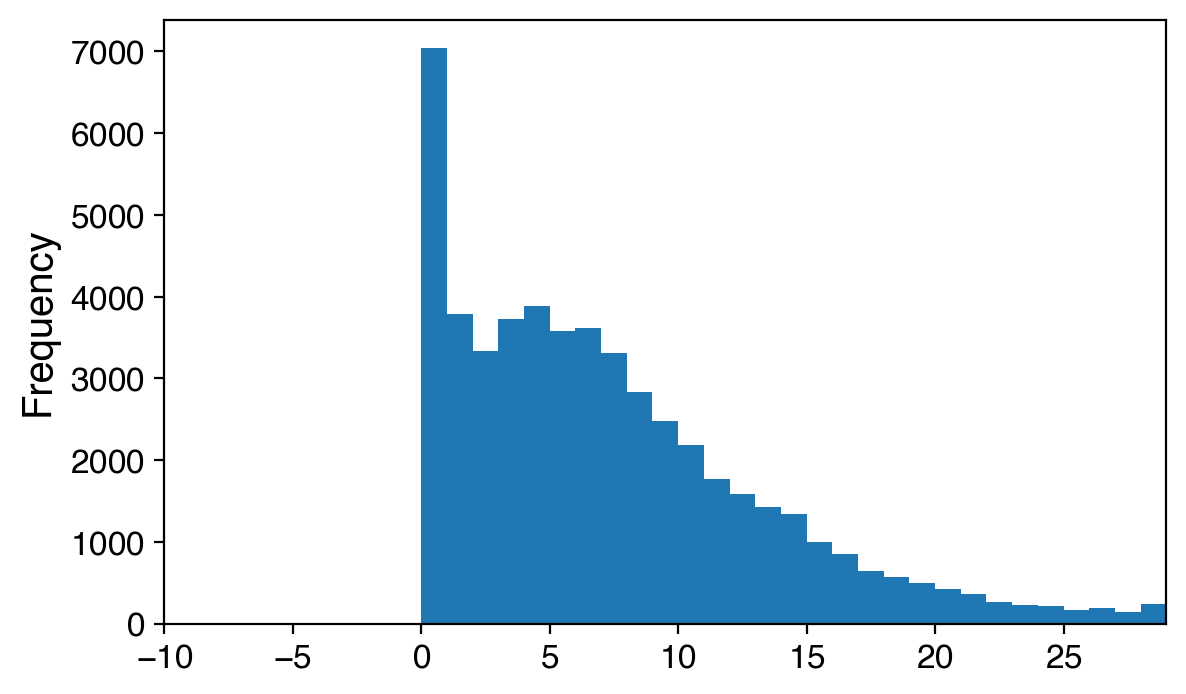

In [13]:
# df = dfc.query("died")
df = dfc.query("not died and known_status")
((df["case"]-df["eventdate"]).dt.days).plot.hist(bins=np.arange(-10,30))

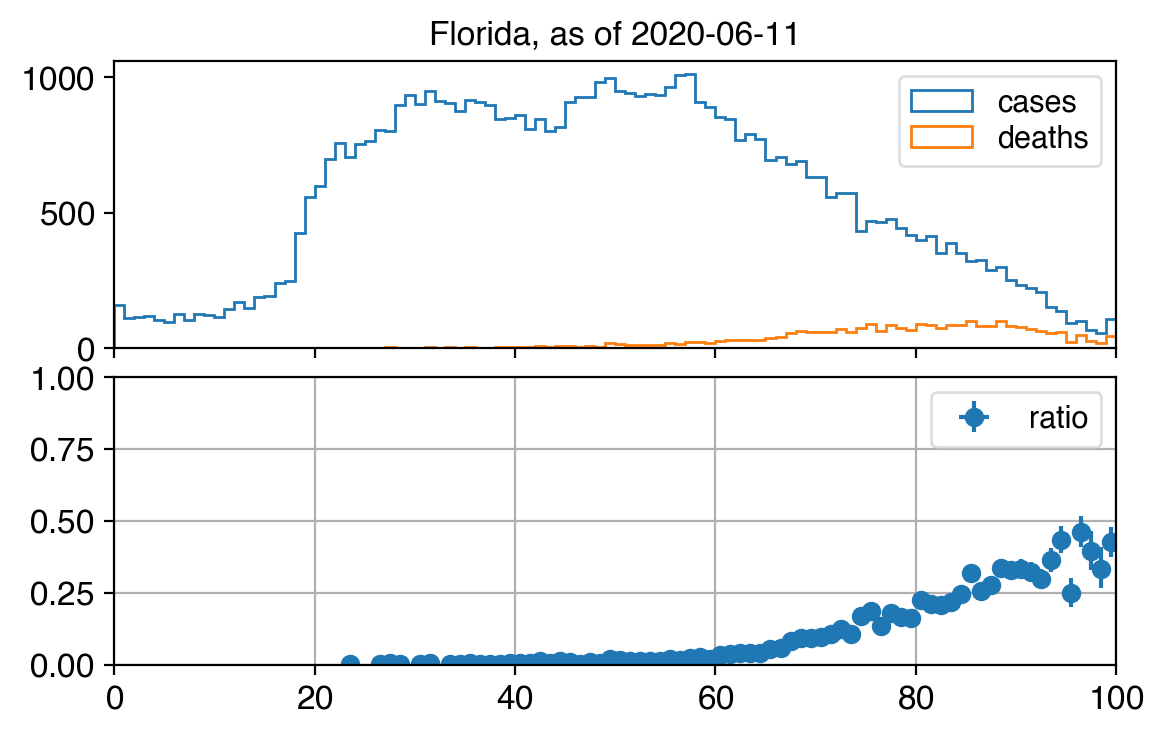

In [14]:
fig, (ax1,ax2) = plt.subplots(2,sharex=True)

bins = "100,0,100"

# dfnumer = dfc.query("died")
dfnumer = dfc.query("died and known_status")
dfdenom = dfc.query("known_status")

hnumer = Hist1D(dfnumer["age"],bins=bins)
hdenom = Hist1D(dfdenom["age"],bins=bins)

hdenom.plot(ax=ax1, label="cases", histtype="step")
hnumer.plot(ax=ax1, label="deaths", histtype="step")

# ax1.set_yscale("log")

hratio = hnumer.divide(hdenom,binomial=True)
hratio.plot(ax=ax2, show_errors=True, label="ratio")

ax1.set_title(f"Florida, as of {str(dfc['case'].max()).split()[0]}")
ax2.set_ylim(bottom=0.,top=1.)
ax1.legend()
ax2.legend()
ax2.grid()

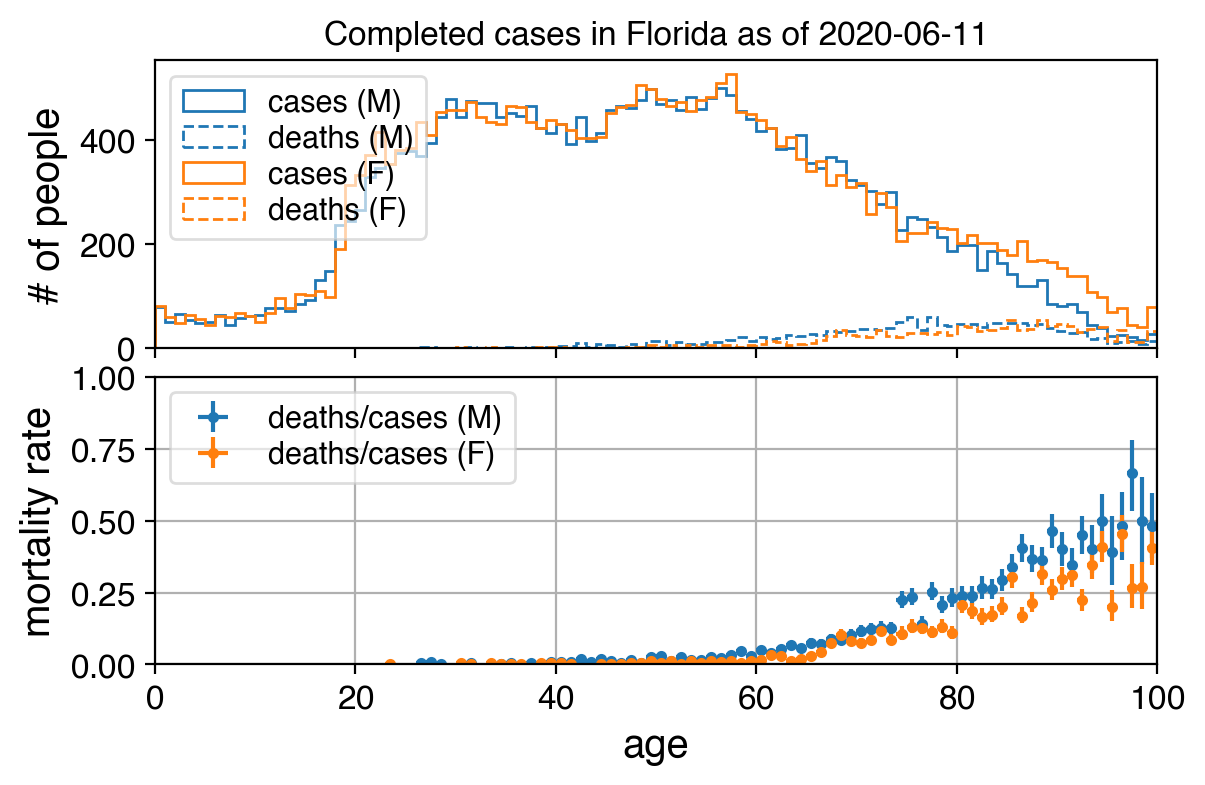

In [15]:

fig, (ax1,ax2) = plt.subplots(2,sharex=True)

def hists_gender(gender, bins="100,0,100", known=True):
    if gender in ["M","F"]:
        selstr = f"gender=='{gender}'"
    else:
        selstr = "gender!='X'"
    if known:
        selstr += " and known_status"
    dfnumer = dfc.query(selstr + " and died")
    dfdenom = dfc.query(selstr)
    hnumer = Hist1D(dfnumer["age"],bins=bins)
    hdenom = Hist1D(dfdenom["age"],bins=bins)
    hratio = hnumer.divide(hdenom,binomial=True)
    return hnumer, hdenom, hratio

hnumer, hdenom, hratio = hists_gender("M")
hdenom.plot(ax=ax1, label="cases (M)", histtype="step", color="C0")
hnumer.plot(ax=ax1, label="deaths (M)", histtype="step", color="C0", linestyle="--")
hratio.plot(ax=ax2, show_errors=True, label="deaths/cases (M)", color="C0", ms=3)

hnumer, hdenom, hratio = hists_gender("F")
hdenom.plot(ax=ax1, label="cases (F)", histtype="step", color="C1")
hnumer.plot(ax=ax1, label="deaths (F)", histtype="step", color="C1", linestyle="--")
hratio.plot(ax=ax2, show_errors=True, label="deaths/cases (F)", color="C1", ms=3)

# hnumer, hdenom, hratio = hists_gender("M", known=False)
# hdenom.plot(ax=ax1, label="cases (M), all", histtype="step", color="C2")
# hnumer.plot(ax=ax1, label="deaths (M), all", histtype="step", color="C2", linestyle="--")
# hratio.plot(ax=ax2, show_errors=True, label="deaths/cases (M), all", color="C2", ms=3)

# hnumer, hdenom, hratio = hists_gender("F", known=False)
# hdenom.plot(ax=ax1, label="cases (F), all", histtype="step", color="C3")
# hnumer.plot(ax=ax1, label="deaths (F), all", histtype="step", color="C3", linestyle="--")
# hratio.plot(ax=ax2, show_errors=True, label="deaths/cases (F), all", color="C3", ms=3)


last = str(dfc['case'].max()).split()[0]
ax1.set_title(f"Completed cases in Florida as of {last}")
# ax1.set_yscale("log")
ax1.legend(loc="upper left")
ax1.set_ylabel("# of people")

ax2.legend(loc="upper left")
ax2.set_ylabel("mortality rate")
ax2.set_ylim(bottom=0.,top=1.0)
ax2.set_xlabel("age")
ax2.grid()

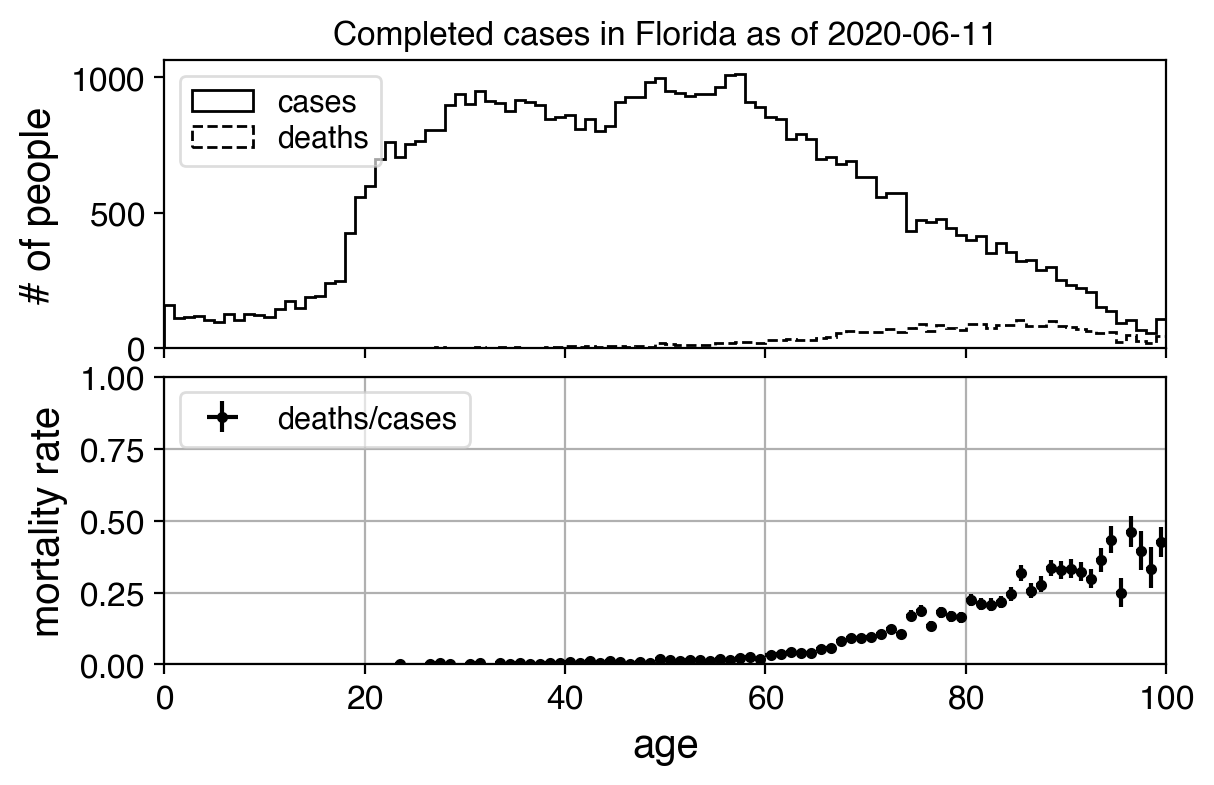

In [16]:
fig, (ax1,ax2) = plt.subplots(2,sharex=True)

hnumer, hdenom, hratio = hists_gender("X", bins="100,0,100")
hdenom.plot(ax=ax1, label="cases", histtype="step", color="k")
hnumer.plot(ax=ax1, label="deaths", histtype="step", color="k", linestyle="--")
hratio.plot(ax=ax2, show_errors=True, label="deaths/cases", color="k", ms=3)

last = str(dfc['case'].max()).split()[0]
ax1.set_title(f"Completed cases in Florida as of {last}")
# ax1.set_yscale("log")
ax1.legend(loc="upper left")
ax1.set_ylabel("# of people")

ax2.legend(loc="upper left")
ax2.set_ylabel("mortality rate")
ax2.set_ylim(bottom=0.,top=1.0)
ax2.set_xlabel("age")
ax2.grid()

In [17]:
(hnumer.counts * hnumer.bin_centers).sum() / hnumer.counts.sum()

77.80842490842491

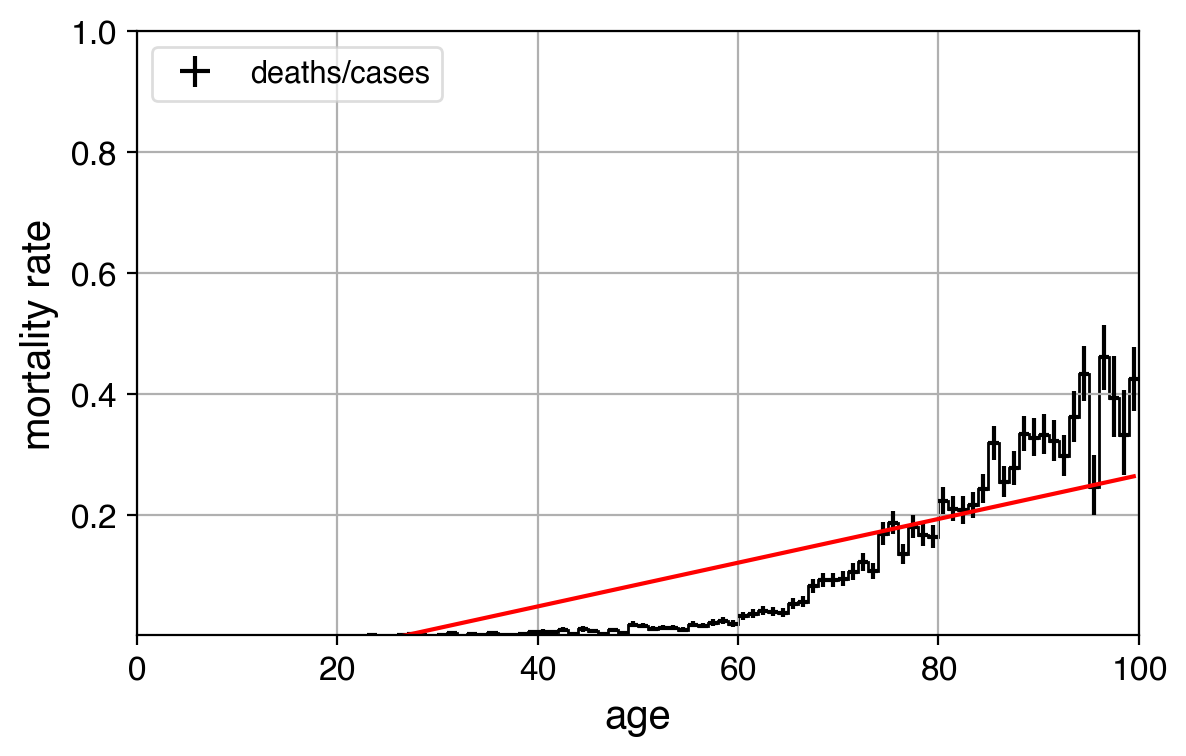

In [18]:
fig, ax = plt.subplots()

hratio = hists_gender("X")[-1]
hratio.plot(ax=ax, color="k", histtype="step")
hratio.plot(ax=ax, show_errors=True, label="deaths/cases", color="k", ms=0)

xs = hratio.bin_centers
ys = hratio.counts
coef = np.polyfit(xs,ys,1)
yfits = np.poly1d(coef)(xs)
ax.plot(xs,yfits,color="r")

ax.legend(loc="upper left")
ax.set_ylabel("mortality rate")
ax.set_ylim(bottom=0.001,top=1.0)
# ax.set_yscale("log")
ax.set_xlabel("age")
ax.grid()

array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
       11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
       22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
       33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5,
       44.5, 45.5, 46.5, 47.5, 48.5, 49.5, 50.5, 51.5, 52.5, 53.5, 54.5,
       55.5, 56.5, 57.5, 58.5, 59.5, 60.5, 61.5, 62.5, 63.5, 64.5, 65.5,
       66.5, 67.5, 68.5, 69.5, 70.5, 71.5, 72.5, 73.5, 74.5, 75.5, 76.5,
       77.5, 78.5, 79.5, 80.5, 81.5, 82.5, 83.5, 84.5, 85.5, 86.5, 87.5,
       88.5, 89.5, 90.5, 91.5, 92.5, 93.5, 94.5, 95.5, 96.5, 97.5, 98.5,
       99.5])

array([ 4.34838476e-02,  3.87832887e-02,  3.42522639e-02,  2.98907731e-02,
        2.56988164e-02,  2.16763938e-02,  1.78235053e-02,  1.41401508e-02,
        1.06263304e-02,  7.28204411e-03,  4.10729186e-03,  1.10207368e-03,
       -1.73361043e-03, -4.39976047e-03, -6.89637644e-03, -9.22345834e-03,
       -1.13810062e-02, -1.33690199e-02, -1.51874996e-02, -1.68364452e-02,
       -1.83158568e-02, -1.96257342e-02, -2.07660776e-02, -2.17368870e-02,
       -2.25381622e-02, -2.31699034e-02, -2.36321105e-02, -2.39247836e-02,
       -2.40479226e-02, -2.40015275e-02, -2.37855983e-02, -2.34001351e-02,
       -2.28451378e-02, -2.21206064e-02, -2.12265409e-02, -2.01629414e-02,
       -1.89298078e-02, -1.75271402e-02, -1.59549384e-02, -1.42132026e-02,
       -1.23019327e-02, -1.02211288e-02, -7.97079079e-03, -5.55091870e-03,
       -2.96151254e-03, -2.02572309e-04,  2.72590199e-03,  5.82391036e-03,
        9.09145281e-03,  1.25285293e-02,  1.61351399e-02,  1.99112846e-02,
        2.38569633e-02,  

In [19]:
# bins = "25,0,100"
bins = "1,0,100"
mdr = hists_gender("M",bins=bins)[-1]
fdr = hists_gender("F",bins=bins)[-1]
# mdr.plot(show_errors=True)
# fdr.plot(show_errors=True)

mdr/fdr
# fig, ax = plt.subplots()
# (mdr/fdr).plot(ax=ax,show_errors=True)
# ax.set_ylim([0,2])

bin,content
"(0,100)",1.33702 ± 0.0551587


In [20]:
mu = (mdr/fdr).counts[0]
err = (mdr/fdr).errors[0]
nsig = (mu-1)/err
print(nsig)

6.109986282959993


In [21]:
bins = np.linspace(0,100,11).astype(int)
pd.cut(np.clip(dfc["age"],0.1,99.9), bins=bins, right=False).value_counts().sort_index()

[0, 10)       868
[10, 20)     1940
[20, 30)     7373
[30, 40)     8769
[40, 50)     8925
[50, 60)     9580
[60, 70)     7562
[70, 80)     5248
[80, 90)     3621
[90, 100)    1443
Name: age, dtype: int64

In [22]:
pd.cut(np.clip(dfc.query("died")["age"],0.1,99.9), bins=bins, right=False).value_counts().sort_index()

[0, 10)        0
[10, 20)       0
[20, 30)       5
[30, 40)      25
[40, 50)      71
[50, 60)     152
[60, 70)     376
[70, 80)     651
[80, 90)     806
[90, 100)    444
Name: age, dtype: int64

In [23]:
print(dfc["gender"].value_counts())
print(dfc.query("died")["gender"].value_counts())

F    27936
M    27393
Name: gender, dtype: int64
M    1418
F    1112
Name: gender, dtype: int64
